C:\Users\harry\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\harry\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Dummy Regressor
RMSE: 50.953696750543536
R^2: -8.475478675995518e-06

Linear Regression
RMSE: 45.564644545665615
R^2: 0.2003346871193874

Ridge Regression
Best alpha: 100
RMSE: 45.56465658818981
R^2: 0.20033426442366586

Random Forest
RMSE: 41.57256375473145
R^2: 0.33431939955719414

K-Nearest Neighbors
RMSE: 49.69054993451987
R^2: 0.04895757432503656


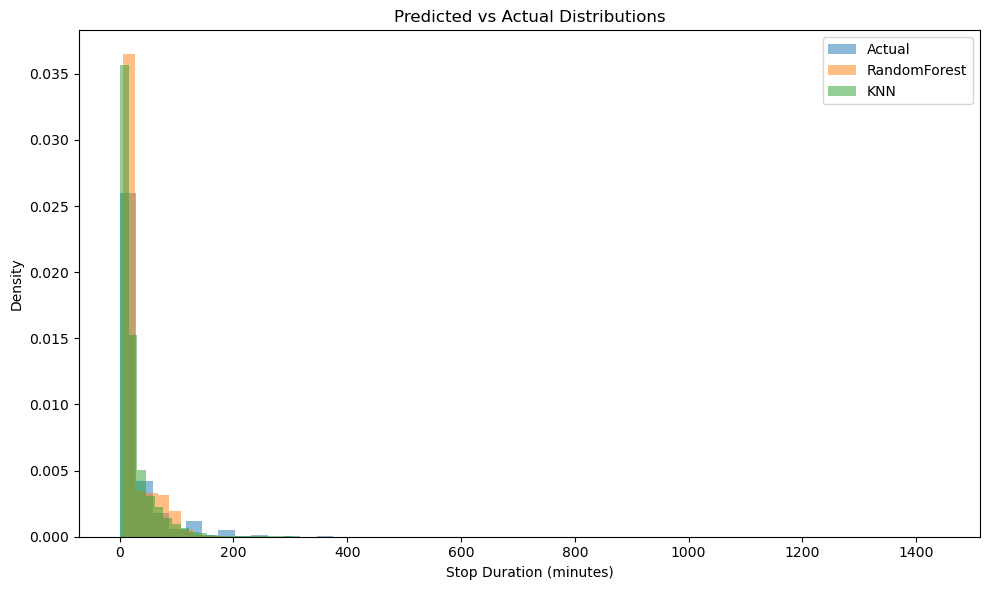

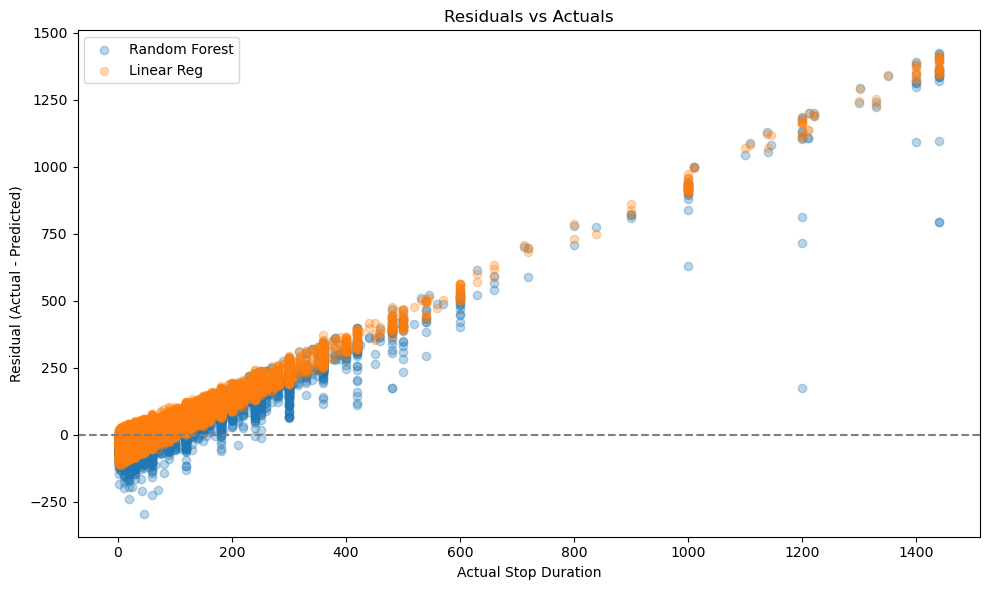

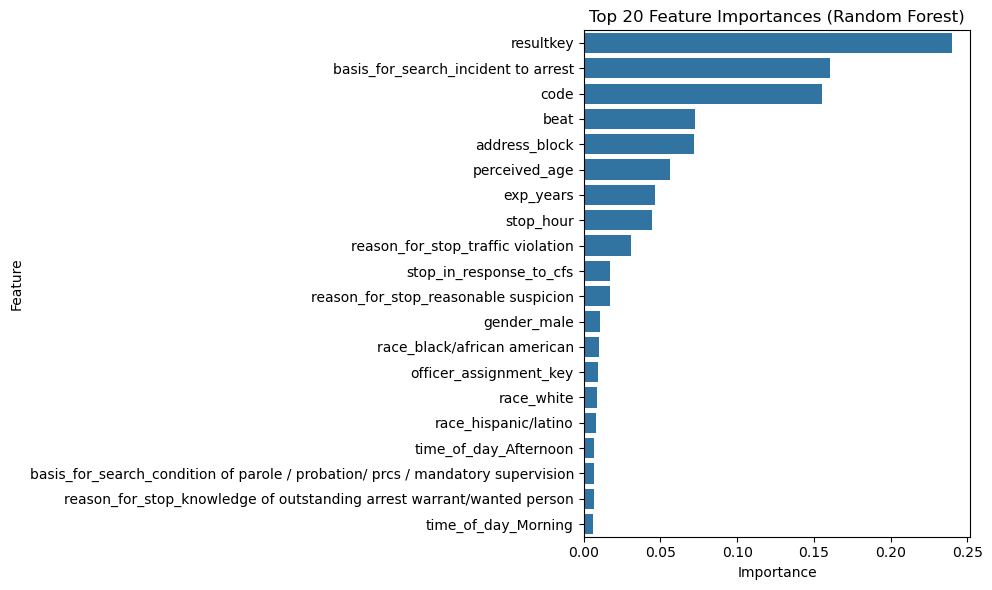


Model Performance Summary:


,Model,RMSE,R2
3,Random Forest,41.572564,0.334319
1,Linear Regression,45.564645,0.200335
2,Ridge Regression,45.564657,0.200334
4,K-Nearest Neighbors,49.690550,0.048958
0,Dummy Regressor,50.953697,-0.000008


Random Forest (Train Performance)
RMSE: 35.64802714030178
R^2: 0.48926263178328566
Bootstrapped Random Forest RMSE Range: 41.674837463204604 - 42.018637116522655
Bootstrapped Random Forest R^2 Range: 0.31995726013835435 - 0.33104005557810046


In [17]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
csv_directory = "C:/Users/harry/Documents/GitHub/SB/Springboard/Capstone 2/data"
X_train = pd.read_csv(os.path.join(csv_directory, "X_train.csv"))
X_test = pd.read_csv(os.path.join(csv_directory, "X_test.csv"))
y_train = pd.read_csv(os.path.join(csv_directory, "y_train.csv")).values.ravel()
y_test = pd.read_csv(os.path.join(csv_directory, "y_test.csv")).values.ravel()

# Feature Pruning Using Random Forest
rf_selector = RandomForestRegressor(n_estimators=25, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)
selector = SelectFromModel(rf_selector, threshold="median", prefit=True)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
selected_features = np.array(pd.read_csv(os.path.join(csv_directory, "X_train.csv")).columns)[selector.get_support()]

# Dummy Regressor Baseline
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("\nDummy Regressor")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dummy)))
print("R^2:", r2_score(y_test, y_pred_dummy))

# Baseline Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)

print("\nLinear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R^2:", r2_score(y_test, y_pred_lr))

# Ridge Regression with Tuning
ridge = Ridge()
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_root_mean_squared_error")
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

print("\nRidge Regression")
print("Best alpha:", ridge_cv.best_params_["alpha"])
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R^2:", r2_score(y_test, y_pred_ridge))

# Random Forest Regressor (Non-linear, simplified)
rf = RandomForestRegressor(
    n_estimators=25,
    max_depth=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R^2:", r2_score(y_test, y_pred_rf))

# K-Nearest Neighbors Regressor 
knn = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(X_train[:10000], y_train[:10000])
y_pred_knn = knn.predict(X_test)

print("\nK-Nearest Neighbors")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("R^2:", r2_score(y_test, y_pred_knn))

# Visual Comparison (Histograms)
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label="Actual", density=True)
plt.hist(y_pred_rf, bins=50, alpha=0.5, label="RandomForest", density=True)
plt.hist(y_pred_knn, bins=50, alpha=0.5, label="KNN", density=True)
plt.title("Predicted vs Actual Distributions")
plt.xlabel("Stop Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Residual Plots
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred_rf, alpha=0.3, label="Random Forest")
plt.scatter(y_test, y_test - y_pred_lr, alpha=0.3, label="Linear Reg")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Actuals")
plt.xlabel("Actual Stop Duration")
plt.ylabel("Residual (Actual - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance (Random Forest)
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({"Feature": selected_features, "Importance": importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# Summary Table of Model Performance
summary_data = {
    "Model": [
        "Dummy Regressor",
        "Linear Regression",
        "Ridge Regression",
        "Random Forest",
        "K-Nearest Neighbors"
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_dummy)),
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_knn))
    ],
    "R2": [
        r2_score(y_test, y_pred_dummy),
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_knn)
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
display(summary_df.sort_values(by="R2", ascending=False))

plt.figure(figsize=(8, 4))
sns.barplot(data=summary_df, x='Model', y='R2')
plt.title("Model R² Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Train vs Test Performance for Random Forest
train_pred_rf = rf.predict(X_train)
print("Random Forest (Train Performance)")
print("RMSE:", np.sqrt(mean_squared_error(y_train, train_pred_rf)))
print("R^2:", r2_score(y_train, train_pred_rf))

# Bootstrapping Random Forest Performance
np.random.seed(42)
n_boot = 20
boot_rmse = []
boot_r2 = []
for _ in range(n_boot):
    idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    Xb, yb = X_train[idx], y_train[idx]
    rf_b = RandomForestRegressor(n_estimators=25, max_depth=15, max_features='sqrt', n_jobs=-1, random_state=42)
    rf_b.fit(Xb, yb)
    pred_b = rf_b.predict(X_test)
    boot_rmse.append(np.sqrt(mean_squared_error(y_test, pred_b)))
    boot_r2.append(r2_score(y_test, pred_b))

print("Bootstrapped Random Forest RMSE Range:", min(boot_rmse), "-", max(boot_rmse))
print("Bootstrapped Random Forest R^2 Range:", min(boot_r2), "-", max(boot_r2))